# Time Series Forecasting: Cumulative GitHub Stars

## 1 - Dataset Preparation

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from pathlib import Path
import random
import math

# Classical TS
from statsmodels.tsa.arima.model import ARIMA

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")
print("Using device:", device)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

ROOT = Path.cwd().parent  # .../assignment-5-atharvv04
DATA_Q3 = ROOT / "Data" / "Q3" / "stars_data.csv"
META_Q3 = ROOT / "Data" / "Q3" / "repo_metadata.json"

print("Stars data path:", DATA_Q3)
print("Metadata path  :", META_Q3)

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return math.sqrt(np.mean((y_true - y_pred) ** 2))

def add_username(tag="atharv.bhatt"):
    plt.text(
        0.95, 0.95, tag,
        ha="right", va="top",
        transform=plt.gca().transAxes,
        fontsize=10, color="gray", alpha=0.7
    )

Using device: cpu
Stars data path: c:\Users\athar\Documents\VS_Code\SEM_5\SMAI\assignment-5-atharvv04\Data\Q3\stars_data.csv
Metadata path  : c:\Users\athar\Documents\VS_Code\SEM_5\SMAI\assignment-5-atharvv04\Data\Q3\repo_metadata.json


In [14]:
# Load stars data
df = pd.read_csv(DATA_Q3, parse_dates=["timestamp"])
print("Raw shape:", df.shape)
print(df.head())

# Drop exact duplicate records (timestamp, repo)
df = df.drop_duplicates(subset=["timestamp", "repository_id"])
print("Shape after dropping duplicates:", df.shape)

# Quick overview of repos and max stars (to see capped-at-4000 ones)
repo_max = df.groupby("repository_id")["stars"].max().sort_values(ascending=False)
print("\nMax stars per repo:")
print(repo_max)

# Identify repos that hit or exceed 4000 (capped)
cap_value = 4000
capped_repos = repo_max[repo_max >= cap_value].index.tolist()
print("\nRepos capped at >= 4000 stars:", capped_repos)

# We'll focus only on React and Flask as per TA note
target_repos = ["facebook/react", "pallets/flask"]
print("\nTarget repos:", target_repos)

# Load metadata (optional, just to inspect)
try:
    with open(META_Q3, "r", encoding="utf-8") as f:
        meta = json.load(f)
    print("\nMetadata keys example (first repo):")
    first_key = list(meta.keys())[0]
    print(first_key, "->", meta[first_key])
except FileNotFoundError:
    print("Metadata file not found; continuing without metadata.")
    meta = {}

Raw shape: (23047, 3)
   timestamp  stars   repository_id
0 2013-05-29    178  facebook/react
1 2013-05-30    765  facebook/react
2 2013-05-31    936  facebook/react
3 2013-06-01    981  facebook/react
4 2013-06-02   1007  facebook/react
Shape after dropping duplicates: (23047, 3)

Max stars per repo:
repository_id
facebook/react           4000
golang/go                4000
pallets/flask            4000
tensorflow/tensorflow    4000
torvalds/linux           4000
Name: stars, dtype: int64

Repos capped at >= 4000 stars: ['facebook/react', 'golang/go', 'pallets/flask', 'tensorflow/tensorflow', 'torvalds/linux']

Target repos: ['facebook/react', 'pallets/flask']

Metadata keys example (first repo):
facebook/react -> {'language': 'JavaScript', 'topics': ['declarative', 'frontend', 'javascript', 'library', 'react', 'ui'], 'created_at': '2013-05-24T16:15:54Z', 'description': 'The library for web and native user interfaces.', 'stargazers_count': 240279}


In [15]:
def get_repo_df(df_all, repo_id):
    sub = df_all[df_all["repository_id"] == repo_id].copy()
    sub = sub.sort_values("timestamp")
    return sub

def build_daily_cumulative(repo_df):
    """
    Take a per-repo DataFrame with columns ['timestamp', 'stars'] and
    return a daily cumulative star Series indexed by timestamp.
    """
    s = repo_df.set_index("timestamp")["stars"].sort_index()
    s = s.asfreq("D")  # daily grid
    s = s.ffill()      # forward-fill cumulative counts
    return s

def build_increment_series(cum_series):
    """
    cum_series: pandas Series of cumulative stars (indexed by date)
    returns: increments Series of same length (first increment = 0)
    """
    incr = cum_series.diff().fillna(0.0)
    return incr

# Build per-repo daily cumulative and increments
repo_series = {}

for repo_id in target_repos:
    sub = get_repo_df(df, repo_id)
    print(f"\nRepo {repo_id}: raw rows = {len(sub)}")
    cum = build_daily_cumulative(sub)
    incr = build_increment_series(cum)
    repo_series[repo_id] = {
        "cum": cum,
        "incr": incr
    }
    print(f"  Daily series length: {len(cum)}; date range: {cum.index.min().date()} -> {cum.index.max().date()}")


Repo facebook/react: raw rows = 4542
  Daily series length: 4542; date range: 2013-05-29 -> 2025-11-03

Repo pallets/flask: raw rows = 5691
  Daily series length: 5691; date range: 2010-04-06 -> 2025-11-03


#### Visualize cumulative & increments + splits (3.2.1, 3.2.2)

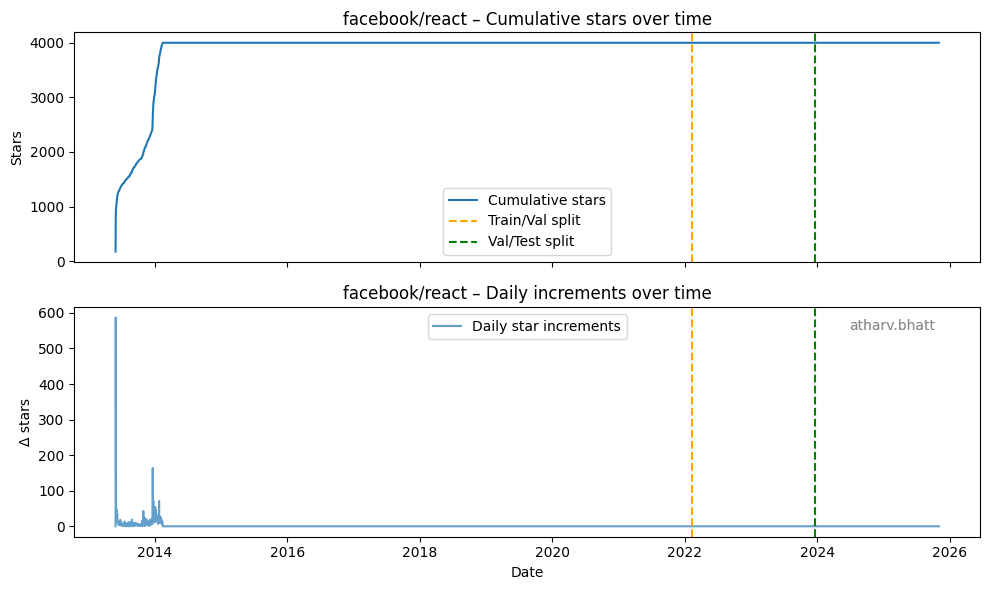

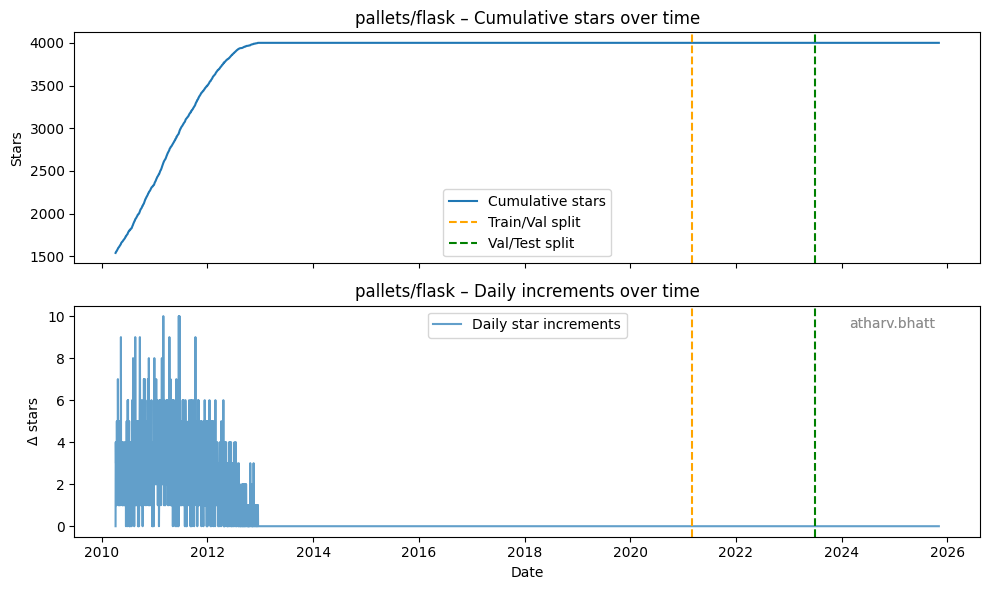

In [16]:
def plot_cum_and_incr_with_splits(repo_id, series_dict, train_frac=0.7, val_frac=0.15):
    cum = series_dict["cum"]
    incr = series_dict["incr"]

    n = len(cum)
    idx_train_end = int(train_frac * n)
    idx_val_end   = int((train_frac + val_frac) * n)

    t = cum.index

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Cumulative
    axes[0].plot(t, cum.values, label="Cumulative stars")
    axes[0].axvline(t[idx_train_end], color="orange", linestyle="--", label="Train/Val split")
    axes[0].axvline(t[idx_val_end], color="green", linestyle="--", label="Val/Test split")
    axes[0].set_title(f"{repo_id} – Cumulative stars over time")
    axes[0].set_ylabel("Stars")
    axes[0].legend()
    add_username()

    # Increments
    axes[1].plot(t, incr.values, label="Daily star increments", alpha=0.7)
    axes[1].axvline(t[idx_train_end], color="orange", linestyle="--")
    axes[1].axvline(t[idx_val_end], color="green", linestyle="--")
    axes[1].set_title(f"{repo_id} – Daily increments over time")
    axes[1].set_ylabel("Δ stars")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    add_username()

    plt.tight_layout()
    plt.show()

for rid in target_repos:
    plot_cum_and_incr_with_splits(rid, repo_series[rid])

#### Train/Val/Test splits & normalization (per repo)

In [17]:
def split_series(cum_series, train_frac=0.7, val_frac=0.15):
    """
    Split a cumulative series into train/val/test segments (chronological).
    Returns (cum_train, cum_val, cum_test).
    """
    n = len(cum_series)
    idx_train_end = int(train_frac * n)
    idx_val_end   = int((train_frac + val_frac) * n)

    cum_train = cum_series.iloc[:idx_train_end]
    cum_val   = cum_series.iloc[idx_train_end:idx_val_end]
    cum_test  = cum_series.iloc[idx_val_end:]
    return cum_train, cum_val, cum_test

def compute_increments_from_split(cum_train, cum_val, cum_test):
    """
    Given split cumulative series, compute corresponding increments
    (no leakage; differencing is within each segment).
    """
    incr_train = cum_train.diff().fillna(0.0)
    incr_val   = cum_val.diff().fillna(0.0)
    incr_test  = cum_test.diff().fillna(0.0)
    return incr_train, incr_val, incr_test

def fit_increment_scaler(incr_train):
    mu = incr_train.mean()
    sigma = incr_train.std()
    if sigma == 0:
        sigma = 1.0
    return float(mu), float(sigma)

def normalize_increments(incr_series, mu, sigma):
    return (incr_series - mu) / sigma

# Build split + normalized increments per repo
repo_data = {}  # store everything here

for repo_id in target_repos:
    print(f"\nProcessing repo: {repo_id}")
    cum_full = repo_series[repo_id]["cum"]

    cum_train, cum_val, cum_test = split_series(cum_full)
    incr_train, incr_val, incr_test = compute_increments_from_split(cum_train, cum_val, cum_test)

    mu, sigma = fit_increment_scaler(incr_train)
    print(f"  Train length: {len(cum_train)}, Val: {len(cum_val)}, Test: {len(cum_test)}")
    print(f"  Increment mean/std (train): {mu:.4f}, {sigma:.4f}")

    incr_train_norm = normalize_increments(incr_train, mu, sigma)
    incr_val_norm   = normalize_increments(incr_val,   mu, sigma)
    incr_test_norm  = normalize_increments(incr_test,  mu, sigma)

    repo_data[repo_id] = {
        "cum_full": cum_full,
        "cum_train": cum_train,
        "cum_val": cum_val,
        "cum_test": cum_test,
        "incr_train": incr_train,
        "incr_val": incr_val,
        "incr_test": incr_test,
        "incr_train_norm": incr_train_norm,
        "incr_val_norm": incr_val_norm,
        "incr_test_norm": incr_test_norm,
        "mu": mu,
        "sigma": sigma
    }


Processing repo: facebook/react
  Train length: 3179, Val: 681, Test: 682
  Increment mean/std (train): 1.2023, 12.1940

Processing repo: pallets/flask
  Train length: 3983, Val: 854, Test: 854
  Increment mean/std (train): 0.6174, 1.4247


#### Sliding-window dataset & DataLoader for DL models

In [18]:
class WindowDataset(Dataset):
    def __init__(self, series, window_size):
        """
        series: 1D numpy array or pandas Series (normalized increments)
        window_size: L
        """
        arr = np.asarray(series, dtype=np.float32)
        self.X, self.y = self._make_windows(arr, window_size)

    @staticmethod
    def _make_windows(arr, L):
        X, y = [], []
        for i in range(L, len(arr)):
            X.append(arr[i-L:i])
            y.append(arr[i])
        if len(X) == 0:
            return np.empty((0, L), dtype=np.float32), np.empty((0,), dtype=np.float32)
        return np.stack(X), np.array(y, dtype=np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]         # ndarray (L,)
        y = self.y[idx]         # scalar np.float32
        x = torch.from_numpy(x)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

def make_dataloaders_for_repo(repo_id, window_size=30, batch_size=64, shuffle_train=True):
    d = repo_data[repo_id]
    train_ds = WindowDataset(d["incr_train_norm"].values, window_size)
    val_ds   = WindowDataset(d["incr_val_norm"].values,   window_size)
    test_ds  = WindowDataset(d["incr_test_norm"].values,  window_size)

    print(f"{repo_id} – window_size={window_size} -> train/val/test sizes:",
          len(train_ds), len(val_ds), len(test_ds))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Try once for sanity
_ = make_dataloaders_for_repo("facebook/react", window_size=30)
_ = make_dataloaders_for_repo("pallets/flask", window_size=30)

facebook/react – window_size=30 -> train/val/test sizes: 3149 651 652
pallets/flask – window_size=30 -> train/val/test sizes: 3953 824 824


#### DL model classes: RNN & 1D CNN

In [19]:
class RNNForecaster(nn.Module):
    """
    GRU-based forecaster on increment windows.
    Input: (batch, L)
    Output: scalar Δy_hat_t
    """
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, L)
        x_seq = x.unsqueeze(-1)  # -> (batch, L, 1)
        out, h = self.rnn(x_seq)
        last_h = out[:, -1, :]   # (batch, hidden_size)
        return self.fc(last_h).squeeze(-1)


class CNN1DForecaster(nn.Module):
    """
    1D CNN over increment windows.
    Input: (batch, L)
    """
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(32, 1)
        self.window_size = window_size

    def forward(self, x):
        # x: (batch, L)
        x = x.unsqueeze(1)  # (batch, 1, L)
        x = self.relu(self.conv1(x))  # (batch, 16, L)
        x = self.relu(self.conv2(x))  # (batch, 32, L)
        # Global average pooling over time dimension
        x = x.mean(dim=2)  # (batch, 32)
        return self.fc(x).squeeze(-1)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Generic training loop for DL models

In [20]:
def train_dl_model(model, train_loader, val_loader,
                   num_epochs=40, lr=1e-3, verbose=True):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        train_loss_sum = 0.0
        n_train = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * len(y_batch)
            n_train += len(y_batch)

        epoch_train_loss = train_loss_sum / max(n_train, 1)
        train_losses.append(epoch_train_loss)

        # ---- Validation ----
        model.eval()
        val_loss_sum = 0.0
        n_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss_sum += loss.item() * len(y_batch)
                n_val += len(y_batch)

        epoch_val_loss = val_loss_sum / max(n_val, 1)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1:03d}/{num_epochs} "
                  f"Train MSE={epoch_train_loss:.4f} Val MSE={epoch_val_loss:.4f}")

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses, best_val_loss

#### Train RNN & CNN per repo

In [21]:
window_size = 30
batch_size = 64
num_epochs = 50

dl_models = {}  # store trained models and info

for repo_id in target_repos:
    print(f"\n=== Training DL models for repo: {repo_id} ===")
    train_loader, val_loader, test_loader = make_dataloaders_for_repo(
        repo_id, window_size=window_size, batch_size=batch_size, shuffle_train=True
    )

    # RNN
    rnn_model = RNNForecaster(input_size=1, hidden_size=32, num_layers=1)
    print(f"RNN params: {count_parameters(rnn_model)}")
    train_rnn, val_rnn, best_val_rnn = train_dl_model(
        rnn_model, train_loader, val_loader,
        num_epochs=num_epochs, lr=1e-3, verbose=True
    )

    # CNN
    cnn_model = CNN1DForecaster(window_size=window_size)
    print(f"CNN params: {count_parameters(cnn_model)}")
    train_cnn, val_cnn, best_val_cnn = train_dl_model(
        cnn_model, train_loader, val_loader,
        num_epochs=num_epochs, lr=1e-3, verbose=True
    )

    dl_models[repo_id] = {
        "window_size": window_size,
        "rnn": rnn_model,
        "cnn": cnn_model,
        "train_rnn": train_rnn,
        "val_rnn": val_rnn,
        "train_cnn": train_cnn,
        "val_cnn": val_cnn,
        "best_val_rnn": best_val_rnn,
        "best_val_cnn": best_val_cnn
    }


=== Training DL models for repo: facebook/react ===
facebook/react – window_size=30 -> train/val/test sizes: 3149 651 652
RNN params: 3393
Epoch 001/50 Train MSE=0.1511 Val MSE=0.0003
Epoch 011/50 Train MSE=0.0753 Val MSE=0.0001
Epoch 021/50 Train MSE=0.0647 Val MSE=0.0002
Epoch 031/50 Train MSE=0.0609 Val MSE=0.0000
Epoch 041/50 Train MSE=0.0586 Val MSE=0.0000
Epoch 050/50 Train MSE=0.0566 Val MSE=0.0004
CNN params: 1665
Epoch 001/50 Train MSE=0.1450 Val MSE=0.0000
Epoch 011/50 Train MSE=0.1089 Val MSE=0.0002
Epoch 021/50 Train MSE=0.1006 Val MSE=0.0000
Epoch 031/50 Train MSE=0.0967 Val MSE=0.0000
Epoch 041/50 Train MSE=0.0907 Val MSE=0.0001
Epoch 050/50 Train MSE=0.0894 Val MSE=0.0001

=== Training DL models for repo: pallets/flask ===
pallets/flask – window_size=30 -> train/val/test sizes: 3953 824 824
RNN params: 3393
Epoch 001/50 Train MSE=0.7184 Val MSE=0.0046
Epoch 011/50 Train MSE=0.3219 Val MSE=0.0000
Epoch 021/50 Train MSE=0.3217 Val MSE=0.0005
Epoch 031/50 Train MSE=0.3206 

#### ARIMA (classical) on increments per repo

In [22]:
def fit_best_arima_on_train_val(repo_id, p_q_candidates=[(1,0), (2,0), (2,1)]):
    """
    Fit ARIMA models on train+val increments (raw, not normalized) and
    pick the best (p,q) by validation RMSE.
    """
    d = repo_data[repo_id]

    # Combine train+val increments
    incr_train_val = pd.concat([d["incr_train"], d["incr_val"]])

    best_rmse = float("inf")
    best_order = None
    best_model = None

    for (p, q) in p_q_candidates:
        order = (p, 0, q)
        try:
            model = ARIMA(incr_train_val.values, order=order)
            res = model.fit()
            # Quick in-sample evaluation on val portion only
            # Forecast length = len(val)
            n_val = len(d["incr_val"])
            forecast = res.forecast(steps=n_val)
            val_true = d["incr_val"].values
            val_rmse = rmse(val_true, forecast)
            print(f"{repo_id} ARIMA{order}: Val RMSE={val_rmse:.4f}")
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_order = order
                best_model = res
        except Exception as e:
            print(f"{repo_id} ARIMA{order} failed: {e}")
            continue

    print(f"Best ARIMA for {repo_id}: order={best_order}, Val RMSE={best_rmse:.4f}")
    return best_model, best_order, best_rmse

arima_models = {}

for repo_id in target_repos:
    print(f"\n=== Fitting ARIMA for repo: {repo_id} ===")
    best_model, best_order, best_rmse_val = fit_best_arima_on_train_val(repo_id)
    arima_models[repo_id] = {
        "model": best_model,
        "order": best_order,
        "val_rmse": best_rmse_val
    }


=== Fitting ARIMA for repo: facebook/react ===
facebook/react ARIMA(1, 0, 0): Val RMSE=0.9893
facebook/react ARIMA(2, 0, 0): Val RMSE=1.1597


C:\Users\athar\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\athar\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


facebook/react ARIMA(2, 0, 1): Val RMSE=6.8814
Best ARIMA for facebook/react: order=(1, 0, 0), Val RMSE=0.9893

=== Fitting ARIMA for repo: pallets/flask ===
pallets/flask ARIMA(1, 0, 0): Val RMSE=0.5068
pallets/flask ARIMA(2, 0, 0): Val RMSE=0.5055
pallets/flask ARIMA(2, 0, 1): Val RMSE=0.1160
Best ARIMA for pallets/flask: order=(2, 0, 1), Val RMSE=0.1160


#### Single-step evaluation on test: ARIMA vs RNN vs CNN (cumulative)


=== Single-step test evaluation for facebook/react ===


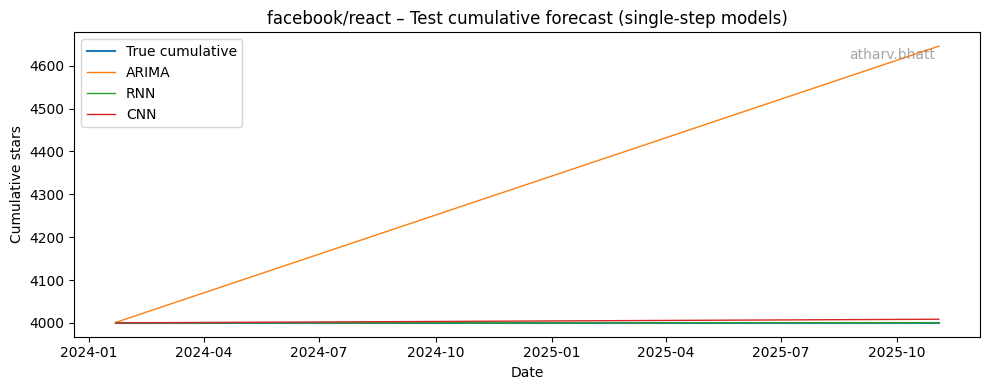

{'ARIMA_MAE': np.float64(323.2854552594477), 'ARIMA_RMSE': 373.15494537346603, 'RNN_MAE': np.float64(0.24867159128189087), 'RNN_RMSE': 0.2870312677267129, 'CNN_MAE': np.float64(4.273633289190889), 'CNN_RMSE': 4.932873951833772}

=== Single-step test evaluation for pallets/flask ===


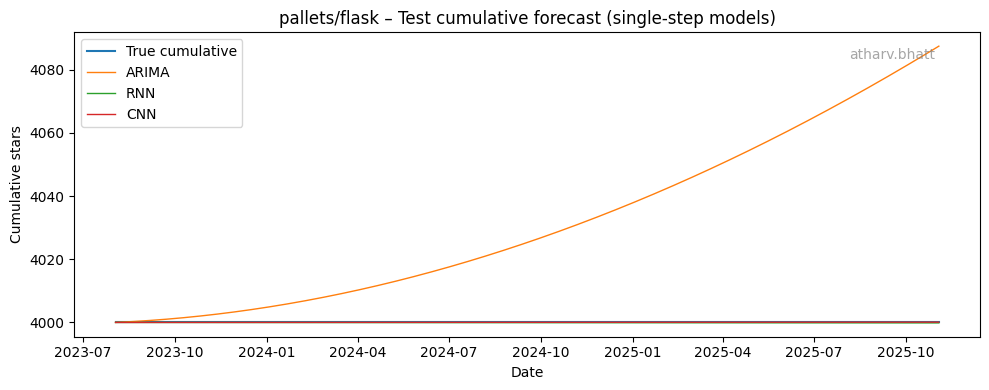

{'ARIMA_MAE': np.float64(31.461728684102653), 'ARIMA_RMSE': 40.812030453626384, 'RNN_MAE': np.float64(0.07036775350570679), 'RNN_RMSE': 0.08122905679765272, 'CNN_MAE': np.float64(0.04401057958602905), 'CNN_RMSE': 0.05080363789930062}


,ARIMA_MAE,ARIMA_RMSE,RNN_MAE,RNN_RMSE,CNN_MAE,CNN_RMSE
facebook/react,323.285455,373.154945,0.248672,0.287031,4.273633,4.932874
pallets/flask,31.461729,40.812030,0.070368,0.081229,0.044011,0.050804


In [23]:
def reconstruct_cumulative_from_increments(last_cum_value, incr_pred):
    """
    last_cum_value: scalar cumulative at start of forecast
    incr_pred: 1D array of predicted increments
    returns: 1D array of predicted cumulative values
    """
    cum = np.cumsum(incr_pred) + last_cum_value
    return cum

def evaluate_repo_on_test(repo_id, dl_models, arima_models):
    d = repo_data[repo_id]
    cum_test = d["cum_test"]
    incr_test = d["incr_test"]
    incr_test_norm = d["incr_test_norm"].values
    mu, sigma = d["mu"], d["sigma"]

    # Last cumulative value before test
    cum_train_val = pd.concat([d["cum_train"], d["cum_val"]])
    last_cum_before_test = cum_train_val.iloc[-1]

    # --- ARIMA: forecast on increments ---
    n_test = len(incr_test)
    arima_res = arima_models[repo_id]["model"]
    arima_forecast_incr = arima_res.forecast(steps=n_test)
    arima_forecast_cum = reconstruct_cumulative_from_increments(
        last_cum_before_test, arima_forecast_incr
    )

    # --- RNN & CNN: sliding windows on normalized increments ---
    window_size = dl_models[repo_id]["window_size"]

    # Build windows on incr_test_norm
    X_test, y_test = WindowDataset._make_windows(incr_test_norm, window_size)
    # Align with timestamps (skip first window_size positions)
    test_dates = cum_test.index[window_size:]  # same alignment as y_test/X_test

    X_test_tensor = torch.from_numpy(X_test).float().to(device)

    # RNN
    rnn_model = dl_models[repo_id]["rnn"].to(device)
    rnn_model.eval()
    with torch.no_grad():
        rnn_preds_norm = rnn_model(X_test_tensor).cpu().numpy()
    rnn_preds_incr = rnn_preds_norm * sigma + mu

    # CNN
    cnn_model = dl_models[repo_id]["cnn"].to(device)
    cnn_model.eval()
    with torch.no_grad():
        cnn_preds_norm = cnn_model(X_test_tensor).cpu().numpy()
    cnn_preds_incr = cnn_preds_norm * sigma + mu

    # For fair comparison, reconstruct cumulative for the overlapping part
    true_incr_for_windows = incr_test.values[window_size:]
    cum_true_for_windows = reconstruct_cumulative_from_increments(
        last_cum_before_test, true_incr_for_windows
    )
    cum_arima_for_windows = reconstruct_cumulative_from_increments(
        last_cum_before_test, arima_forecast_incr[window_size:]
    )
    cum_rnn_for_windows = reconstruct_cumulative_from_increments(
        last_cum_before_test, rnn_preds_incr
    )
    cum_cnn_for_windows = reconstruct_cumulative_from_increments(
        last_cum_before_test, cnn_preds_incr
    )

    # Compute MAE/RMSE in cumulative space
    mae_arima = mae(cum_true_for_windows, cum_arima_for_windows)
    rmse_arima = rmse(cum_true_for_windows, cum_arima_for_windows)
    mae_rnn = mae(cum_true_for_windows, cum_rnn_for_windows)
    rmse_rnn = rmse(cum_true_for_windows, cum_rnn_for_windows)
    mae_cnn = mae(cum_true_for_windows, cum_cnn_for_windows)
    rmse_cnn = rmse(cum_true_for_windows, cum_cnn_for_windows)

    metrics = {
        "ARIMA_MAE": mae_arima,
        "ARIMA_RMSE": rmse_arima,
        "RNN_MAE": mae_rnn,
        "RNN_RMSE": rmse_rnn,
        "CNN_MAE": mae_cnn,
        "CNN_RMSE": rmse_cnn
    }

    # Plot representative forecast on last part of test
    plt.figure(figsize=(10,4))
    plt.plot(test_dates, cum_true_for_windows, label="True cumulative", linewidth=1.5)
    plt.plot(test_dates, cum_arima_for_windows, label="ARIMA", linewidth=1)
    plt.plot(test_dates, cum_rnn_for_windows, label="RNN", linewidth=1)
    plt.plot(test_dates, cum_cnn_for_windows, label="CNN", linewidth=1)
    plt.title(f"{repo_id} – Test cumulative forecast (single-step models)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative stars")
    plt.legend()
    add_username()
    plt.tight_layout()
    plt.show()

    return metrics

all_metrics = {}

for repo_id in target_repos:
    print(f"\n=== Single-step test evaluation for {repo_id} ===")
    metrics = evaluate_repo_on_test(repo_id, dl_models, arima_models)
    all_metrics[repo_id] = metrics
    print(metrics)

# Show summary table
metrics_df = pd.DataFrame(all_metrics).T
metrics_df

#### Multi-step autoregressive forecasting & error vs horizon


=== Multi-step error vs horizon for facebook/react ===


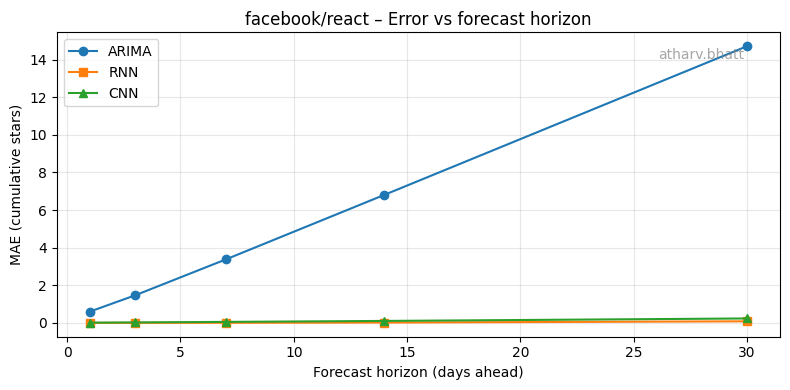


=== Multi-step error vs horizon for pallets/flask ===


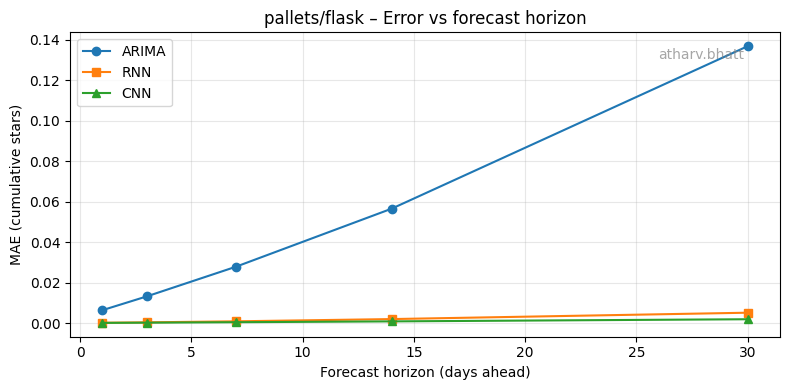

In [25]:
def multi_step_forecast_dl(model, incr_series_norm, window_size, mu, sigma,
                           last_cum_value, horizon):
    """
    Autoregressive multi-step forecast using a DL model on normalized increments.
    incr_series_norm: normalized increment series up to the forecast start (numpy array)
    window_size: window length L
    last_cum_value: starting cumulative value
    horizon: H
    """
    arr = np.asarray(incr_series_norm, dtype=np.float32)
    # Use last window_size true increments as initial history
    hist = arr[-window_size:].copy()
    preds_incr = []

    model.eval()
    with torch.no_grad():
        for h in range(horizon):
            X = torch.from_numpy(hist[None, :]).float().to(device)  # shape (1, L)
            pred_norm = model(X).cpu().numpy().flatten()[0]
            pred_incr = pred_norm * sigma + mu
            preds_incr.append(pred_incr)

            # Update history (keep normalized values in hist)
            hist = np.concatenate([hist[1:], np.array([pred_norm], dtype=np.float32)])

    preds_incr = np.array(preds_incr, dtype=np.float32)
    cum_pred = reconstruct_cumulative_from_increments(last_cum_value, preds_incr)
    return preds_incr, cum_pred


def multi_step_forecast_arima(arima_res, last_cum_value, horizon):
    """
    Autoregressive multi-step forecast using ARIMA model.
    """
    preds_incr = arima_res.forecast(steps=horizon)
    cum_pred = reconstruct_cumulative_from_increments(last_cum_value, preds_incr)
    return np.array(preds_incr, dtype=np.float32), cum_pred


def error_vs_horizon(repo_id, horizons=[1, 3, 7, 14, 30]):
    d = repo_data[repo_id]
    mu, sigma = d["mu"], d["sigma"]

    # Use ONLY train+val increments for initial history (no leakage)
    incr_train_val = pd.concat([d["incr_train"], d["incr_val"]])
    incr_train_val_norm = normalize_increments(incr_train_val, mu, sigma).values

    # last cumulative before test
    cum_train_val = pd.concat([d["cum_train"], d["cum_val"]])
    last_cum_before_test = cum_train_val.iloc[-1]

    rnn_model = dl_models[repo_id]["rnn"].to(device)
    cnn_model = dl_models[repo_id]["cnn"].to(device)
    arima_res = arima_models[repo_id]["model"]
    window_size = dl_models[repo_id]["window_size"]

    mae_arima_list, mae_rnn_list, mae_cnn_list = [], [], []

    cum_test = d["cum_test"].values

    for H in horizons:
        # ARIMA: forecast H steps ahead from last_cum_before_test
        _, cum_pred_arima = multi_step_forecast_arima(arima_res, last_cum_before_test, H)
        true_future = cum_test[:H]
        mae_arima_list.append(mae(true_future, cum_pred_arima))

        # RNN
        _, cum_pred_rnn = multi_step_forecast_dl(
            rnn_model, incr_train_val_norm, window_size, mu, sigma,
            last_cum_before_test, H
        )
        mae_rnn_list.append(mae(true_future, cum_pred_rnn))

        # CNN
        _, cum_pred_cnn = multi_step_forecast_dl(
            cnn_model, incr_train_val_norm, window_size, mu, sigma,
            last_cum_before_test, H
        )
        mae_cnn_list.append(mae(true_future, cum_pred_cnn))

    plt.figure(figsize=(8, 4))
    plt.plot(horizons, mae_arima_list, marker="o", label="ARIMA")
    plt.plot(horizons, mae_rnn_list, marker="s", label="RNN")
    plt.plot(horizons, mae_cnn_list, marker="^", label="CNN")
    plt.xlabel("Forecast horizon (days ahead)")
    plt.ylabel("MAE (cumulative stars)")
    plt.title(f"{repo_id} – Error vs forecast horizon")
    plt.grid(True, alpha=0.3)
    plt.legend()
    add_username()
    plt.tight_layout()
    plt.show()

    return {
        "horizons": horizons,
        "ARIMA_MAE": mae_arima_list,
        "RNN_MAE": mae_rnn_list,
        "CNN_MAE": mae_cnn_list
    }


multi_step_results = {}
for repo_id in target_repos:
    print(f"\n=== Multi-step error vs horizon for {repo_id} ===")
    multi_step_results[repo_id] = error_vs_horizon(repo_id)

In [26]:
print("Single-step cumulative test metrics:")
metrics_df

Single-step cumulative test metrics:


,ARIMA_MAE,ARIMA_RMSE,RNN_MAE,RNN_RMSE,CNN_MAE,CNN_RMSE
facebook/react,323.285455,373.154945,0.248672,0.287031,4.273633,4.932874
pallets/flask,31.461729,40.812030,0.070368,0.081229,0.044011,0.050804
